In [2]:
import numpy as np
import seaborn as sns
from time import time

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.regularizers import L1L2
import keras.backend as K

import os
import gc
from pathlib import Path

tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
init_state = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

In [4]:
class Game:
    def __init__(self, state, FIRST):
        self.state = state
        self.empty = self.make_empty(state)
        self.first_player = FIRST
        
    def make_empty(self, state):
        emp = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == 0:
                    emp.append(3*i + j)
        
        return emp
    
    def is_lose(self, a):
        opp = 2 - (a-1)
        
        for i in range(3):
            if self.state[i][0] == self.state[i][1] == self.state[i][2] == opp:
                return True
            elif self.state[0][i] == self.state[1][i] == self.state[2][i] == opp:
                return True
        if self.state[0][0] == self.state[1][1] == self.state[2][2] == opp:
            return True
        if self.state[0][2] == self.state[1][1] == self.state[2][0] == opp:
            return True
        return 0
    
    def is_win(self, a):       
        for i in range(3):
            if self.state[i][0] == self.state[i][1] == self.state[i][2] == a:
                return True
            elif self.state[0][i] == self.state[1][i] == self.state[2][i] == a:
                return True
        if self.state[0][0] == self.state[1][1] == self.state[2][2] == a:
            return True
        if self.state[0][2] == self.state[1][1] == self.state[2][0] == a:
            return True
        
        return False
    
    def is_draw(self, a):
        if self.is_win(a):
            return 0
        if np.all(self.state):
            return 1
        else:
            return 0
        
    def is_done(self):
        if self.is_win(1) or self.is_win(2) or self.is_draw(1) or self.is_draw(2):
            return 1
        else:
            return 0
        
        
    def update(self, target):
        state = self.state.copy()
        x, y = target//3, target%3
        a = self.next_opp()
        state[x][y] = a
        return Game(state, self.first_player)
    
    
    def next_opp(self):
        a = b = 0
        for i in range(len(self.state)):
            for j in range(len(self.state)):
                if self.state[i][j] == self.first_player:
                    a += 1
                elif self.state[i][j] != 0:
                    b += 1
                    
        if a == b:
            return self.first_player
        else:
            return 2 + min(0, 1-self.first_player)

In [5]:
class Random:
    def __init__(self, status):
        self.status = status

    def action(self, game):
        return np.random.choice(game.empty)

In [ ]:
status = 1

def playout(game):
    if game.is_lose():
        return -1

    if game.is_draw(status):
        return 0


    if game.is_win(status):
        return 1

    return playout(game.update(np.random.choice(game.empty)))


def action(game):
    values = [0] * len(game.empty)

    for i, a in enumerate(game.empty):
        for _ in range(100):
            g = game.update(a)
            values[i] += playout(g)

    return game.empty[np.argmax(values)]

In [6]:
DN_FILTERS = 128  # 컨볼루션 레이어 커널 수(오리지널 256）
DN_RESIDUAL_NUM = 8  # 레지듀얼 블록 수(오리지널 19)
DN_INPUT_SHAPE = (1, 3, 3)  # 입력 셰이프
DN_OUTPUT_SIZE = 9  # 행동 수(배치 수(3*3))
    
def residual_block():
    def f(x):
        sc = x
        x = layers.Conv2D(DN_FILTERS, 3, padding='same', use_bias=False,
              kernel_initializer='he_normal', kernel_regularizer=L1L2(l2=0.0005))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(DN_FILTERS, 3, padding='same', use_bias=False,
              kernel_initializer='he_normal', kernel_regularizer=L1L2(l2=0.0005))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, sc])
        x = layers.Activation('relu')(x)
        return x

    return f
    
def dual_network():
#     # 모델 생성이 완료된 경우 처리하지 않음
#     if os.path.exists('./model/best.h5'):
#         return

    # 입력 레이어
    input = layers.Input(shape=DN_INPUT_SHAPE)

    # 컨볼루션 레이어
    x = layers.Conv2D(DN_FILTERS, 3, padding='same', use_bias=False,
              kernel_initializer='he_normal', kernel_regularizer=L1L2(l2=0.0005))(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 레지듀얼 블록 x 16
    for i in range(DN_RESIDUAL_NUM):
        x = residual_block()(x)

    # 풀링 레이어
    x = layers.GlobalAveragePooling2D()(x)

    # policy 출력
    p = layers.Dense(DN_OUTPUT_SIZE, kernel_regularizer=L1L2(l2=0.0005),
              activation='tanh', name='pi')(x)

    # value 출력
#     v = layers.Dense(1, kernel_regularizer=L1L2(l2=0.0005))(x)
#     v = layers.Activation('tanh', name='v')(v)

    # 모델 생성
    model = models.Model(inputs=input, outputs=p)

    model.compile(optimizer = 'adam',
                 loss = 'logcosh')

    return model

class DQN:
    def __init__(self, status):
        K.clear_session()
#         if os.path.exists('./best.h5'):
#             print('kk')
#             path = sorted(Path('./').glob('*.h5'))[-1]
#             print(path)
#             self.model = models.load_model(str(path))
#         else:
#             self.model = dual_network()
            
#         self.model = models.load_model('./tanh2.h5')
        self.model = dual_network()
        self.status = status
        
    def action(self, game):
        status = self.status
        target = np.reshape(game.state, (1, 1, 3, 3)).astype('float')
        target = np.where(target==status, 1., np.where(target==0, 0, -1.))
        res = self.model.predict(target)[0]
        a = np.argmax(res)
        while a not in game.empty:
            res[a] = -float('inf')
            a = np.argmax(res)
        return a
    
    
#     def playout(self, game):
#         status = self.status
#         if game.is_lose(status):
#             return -1

#         if game.is_draw(status):
#             return 0


#         if game.is_win(status):
#             return 1

#         return self.playout(game.update(np.random.choice(game.empty)))

    def value(self, game):
        values = [0] * 9
        n_steps = 100

        for i in range(9):
            if i in game.empty:
                for _ in range(n_steps):
                    g = game.update(i)
                    values[i] += self.playout(g)
            values[i] /= n_steps
            
        return values

    def train(self):
        for i in [1, 2]:
            game = Game(init_state, i)
            X = []
            y = []
            while 1:
                status = game.next_opp()
                state = np.reshape(game.state, (1, 1, 3, 3)).astype('float')
                state = np.where(state==status, 1., np.where(state==0, 0, -1.))

                X.append(state)
                y.append(self.value(game))

                a = action(game)
                game = game.update(a)

                if game.is_done():
                    break

            X = np.reshape(X, (len(X), 1, 3, 3))
            y = np.reshape(y, (len(y), 9))   
            self.model.fit(X, y, epochs=1, verbose=0)
                
    
    def opp(self, status):
        return 2 + min(0, 1-status)


In [7]:
dd = DQN(1)

In [ ]:
dd.model = models.load_model('./tanh.h5')

In [8]:
dd.train()

In [9]:
for _ in range(1000):
    print(_)
    dd.train()
    
dd.model.save('./tanh3.h5')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
a = init_state.copy()
a = np.reshape(a, (1, 1, 3, 3)).astype('float')
a = np.where(a==1, 1., np.where(a==0, 0, -1.))

dd.model.predict(a)


In [10]:
gc.collect()

20

In [ ]:
# def train(game):
#     global X, y

#     while 1:
#         X.append(np.reshape(game.state, (1, 3, 3)))
#         a1 = action(game)
#         game = game.update(a1)
#         temp_y = [0] * 9
#         temp_y[a1] = 1
#         y.append(temp_y)
    
#         if game.is_win(1):
#             break 
#         elif game.is_draw(1):
#             break 

#         a2 = np.random.choice(game.empty)
#         game = game.update(a2)
#         if game.is_win(2):
#             y *= -1
#             break 
#         elif game.is_draw(2):
#             break
        
#     X = np.reshape(X, (len(X), 1, 3, 3))
#     if len(y) == 0:
#         print('pass')
#         return
#     y = np.reshape(y, (len(X), 9))   

#     k.model.fit(X, y, epochs=1, verbose=0)
# #     return model

In [ ]:
# %%time
# # train n_steps
# FIRST = 1
# k = DQN(1)
# # model = k.model
# g = Game(init_state)
# n_steps = 500
# for _ in range(n_steps):
#     X = []
#     y = []
#     train(g)
#     gc.collect()
#     del X, y

In [11]:
def play(game, m1, m2):
    global score
    while 1:
        a1 = m1.action(game)
        game = game.update(a1)
        if game.is_win(m1.status):
            score[m1.status-1] += 1
            return 
        elif game.is_draw(m1.status):
            score[2] += 1
            return 

        a2 = m2.action(game)
        game = game.update(a2)
        if game.is_win(m2.status):
            score[m2.status-1] += 1
            return 
        elif game.is_draw(m2.status):
            score[2] += 1
            return 
        

In [ ]:
dd.model.predict(np.reshape(init_state, (1, 1, 3, 3))).astype('f')[0]

In [ ]:
dd.status

In [12]:
%%time

m1 = Random(2)
score = [0, 0, 0]

game = Game(init_state, 1)
for _ in range(100):
    print(_)
    play(game, dd, m1)
    
gc.collect()

game = Game(init_state, 2)
score1 = score.copy()
for _ in range(100):
    print(_)
    play(game, m1, dd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Wall time: 2.1 s


In [13]:
score

[94, 84, 22]

In [14]:
score1

[64, 23, 13]

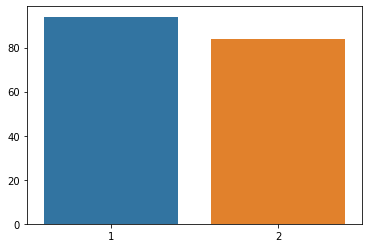

In [15]:
sns.barplot(x = [1, 2], y = score[:2])

In [ ]:
# tanh + mse
# v1: 732vs601 // 350vs323
# v2: 738vs399 // 411vs149
# v3: 1161vs773 // 791vs170
# v4: 1305vs567 // 832vs86